In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Attention, Input
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import os
import random
import joblib

In [2]:
SEED = 215
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [3]:
tf.random.set_seed(0)
data = pd.read_csv('dados_diarios_14Nov_outliers.csv')
data = data.rename(columns={'Daily Power yields (kWh)': 'energy', 'inverterdatetime': 'time'})
data.head()

,time,energy
0,2023-07-12,621.1
1,2023-07-13,772.1
2,2023-07-14,972.8
3,2023-07-15,964.3
4,2023-07-16,643.0


In [4]:
data_power = data['energy']
data_power = np.array(data_power)

In [5]:
scaler = MinMaxScaler()
data_power = data_power.reshape(-1, 1)
normalized_data = scaler.fit_transform(data_power)

joblib.dump(scaler, 'meu_scaler_minmax.joblib')

data_power = pd.Series(
    [value for row in normalized_data for value in row], name="energy"
)

data_power.head()

0    0.174908
1    0.343454
2    0.567474
3    0.557986
4    0.199353
Name: energy, dtype: float64

In [6]:
X = pd.concat([data_power.shift(1), data_power.shift(2), data_power.shift(3),], axis=1)
y = pd.concat([data_power.shift(-3)], axis=1)
X.dropna(inplace=True)
y.dropna(subset=["energy"], inplace=True)
print(X)
print(y)
print(data_power)
X = X.to_numpy()
y = y.to_numpy()
y = y.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, stratify=None
)

       energy    energy    energy
3    0.567474  0.343454  0.174908
4    0.557986  0.567474  0.343454
5    0.199353  0.557986  0.567474
6    0.000000  0.199353  0.557986
7    0.412993  0.000000  0.199353
..        ...       ...       ...
119  0.429289  0.849090  0.953901
120  0.525505  0.429289  0.849090
121  0.851211  0.525505  0.429289
122  0.461882  0.851211  0.525505
123  0.510325  0.461882  0.851211

[121 rows x 3 columns]
       energy
0    0.557986
1    0.199353
2    0.000000
3    0.412993
4    0.321464
..        ...
116  0.525505
117  0.851211
118  0.461882
119  0.510325
120  0.510325

[121 rows x 1 columns]
0      0.174908
1      0.343454
2      0.567474
3      0.557986
4      0.199353
         ...   
119    0.525505
120    0.851211
121    0.461882
122    0.510325
123    0.510325
Name: energy, Length: 124, dtype: float64


In [7]:
print(X)

print(y)

[[0.56747405 0.34345351 0.17490791]
 [0.55798638 0.56747405 0.34345351]
 [0.19935261 0.55798638 0.56747405]
 [0.         0.19935261 0.55798638]
 [0.41299252 0.         0.19935261]
 [0.32146445 0.41299252 0.        ]
 [0.49101462 0.32146445 0.41299252]
 [0.46165867 0.49101462 0.32146445]
 [0.5182498  0.46165867 0.49101462]
 [0.29902891 0.5182498  0.46165867]
 [0.50552517 0.29902891 0.5182498 ]
 [0.23384306 0.50552517 0.29902891]
 [0.33374261 0.23384306 0.50552517]
 [0.47695055 0.33374261 0.23384306]
 [0.47460654 0.47695055 0.33374261]
 [0.51958924 0.47460654 0.47695055]
 [0.54738252 0.51958924 0.47460654]
 [0.55564237 0.54738252 0.51958924]
 [0.50429735 0.55564237 0.54738252]
 [0.53901105 0.50429735 0.55564237]
 [0.53421141 0.53901105 0.50429735]
 [0.55140083 0.53421141 0.53901105]
 [0.53454627 0.55140083 0.53421141]
 [0.53923429 0.53454627 0.55140083]
 [0.54715928 0.53923429 0.53454627]
 [0.47773189 0.54715928 0.53923429]
 [0.3860922  0.47773189 0.54715928]
 [0.51769171 0.3860922  0.47

In [8]:
model = tf.keras.models.load_model('modelo_australia.h5')
model.trainable = False
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1217 (4.75 KB)
_________________________________________________________________
None


In [9]:
for layer in model.layers:
    layer.trainable = False

In [10]:
base_inputs = model.layers[0].input
base_outputs = model.layers[-2].output

output = layers.Dense(1, name='output')(base_outputs)
new_model = tf.keras.Model(inputs=base_inputs, outputs=output)
new_model.summary()


for layer in new_model.layers:
    print("weights:", len(layer.weights))
    print("trainable_weights:", len(layer.trainable_weights))
    print("non_trainable_weights:", len(layer.non_trainable_weights))



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 1184 (4.62 KB)
_________________________________________________________________
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 2
trainable_weights: 0
non_trainabl

In [11]:
y_train = np.array(y_train).astype('float32')

Epoch 1/20
3/3 [==============================] - 0s 63ms/step - loss: 0.0330 - val_loss: 0.1042
Epoch 2/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0325 - val_loss: 0.1030
Epoch 3/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0323 - val_loss: 0.1021
Epoch 4/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0322 - val_loss: 0.1014
Epoch 5/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0321 - val_loss: 0.1010
Epoch 6/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0320 - val_loss: 0.1007
Epoch 7/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0319 - val_loss: 0.1007
Epoch 8/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0317 - val_loss: 0.1007
Epoch 9/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0316 - val_loss: 0.1006
Epoch 10/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0315 - val_loss: 0.1006
Epoch 11/20
3/3 [============

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


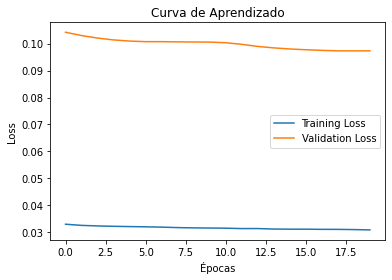

In [12]:
new_model.compile(optimizer='adam', loss='mean_squared_error')


history = new_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3)
new_model.save('modelo.h5')
# Plotar a curva de aprendizado
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de Aprendizado')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Teste as cegas

1/1 [==============================] - 0s 73ms/step
0.15054623229799827
134.87436279296872
[ 990.2423   967.08575  995.7529   984.64954  984.15906  918.19824
  794.81335  710.818    752.97516  687.2359   655.5072   904.55817
 1006.1703   899.4811  1020.63464 1186.5538  1238.4108  1226.9567
 1171.4417   940.8046   929.26794 1089.1257   936.54785  925.79266
  796.3846 ]


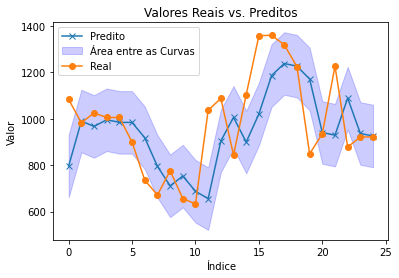

In [13]:
predicoes = new_model.predict(X_test)
rmse = np.mean(((predicoes.reshape(1,-1).flatten() - y_test)**2)**0.5)
print(rmse)
predicoes = scaler.inverse_transform(predicoes)
# print('Presições: ', predicoes)

real = scaler.inverse_transform(y_test.reshape(-1,1))
# print('Real: ', real.reshape(1,-1))

erro_vetor = ((predicoes - real)**2)**0.5
erro = np.mean(((predicoes - real)**2)**0.5)
print(erro)
# print('previsão mais erro: ', np.roll(predicoes, -1) + erro)

indices = np.arange(len(X_test))
print(np.roll(predicoes, -1).reshape(1,-1).flatten())

plt.plot(indices,predicoes, label='Predito', marker='x')
plt.fill_between(indices, (predicoes + erro).reshape(1,-1).flatten(), (predicoes - erro).reshape(1,-1).flatten(),color='blue', alpha=0.2, label='Área entre as Curvas' )
plt.plot(indices,real, label= 'Real', marker='o')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores Reais vs. Preditos')
plt.legend()
plt.show()

In [14]:
c = 0
for r, p in zip(real, predicoes):
    margem_up = r + erro
    margem_down = (r - erro)
    if p > margem_up or p < margem_down:
        c = c + 1

tam = len(predicoes)
print(c)

porcentagem = ((c / tam ))*100
print(f'Fora da margem: {porcentagem} %')

11
Fora da margem: 44.0 %


In [15]:
print(erro)
print(rmse)

134.87436279296872
0.15054623229799827


In [16]:

entrada_lista = [878.2, 921.6, 921.6]
entrada_lista = scaler.transform(np.array(entrada_lista).reshape(-1,1))
entrada_array = np.array([entrada_lista])
previsao = new_model.predict([entrada_array])


previsao_lista = scaler.inverse_transform(previsao).tolist()

print(f'Entrada: {entrada_lista}')
print(f'Previsão: {previsao_lista}')



1/1 [==============================] - 0s 58ms/step
Entrada: [[0.46188191]
 [0.51032481]
 [0.51032481]]
Previsão: [[884.3912963867188]]
